# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import time

#### SW PARAMS
TRAIN = False
TRAINED_FILENAME='./checkpoint.pth' # these weights will be used for the test part
TEST = True
VIS = True
VIS_TEST_SLOW = False

#### ALG PARAMS
TRAIN_EPISODES = 2000
TEST_EPISODES = 100


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
if VIS:
    env = UnityEnvironment(file_name="./Banana_Linux/Banana.x86_64")
else:
    env = UnityEnvironment(file_name="./Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment + test vis
env_info = env.reset(train_mode=True)[brain_name]
env_info = env.step(0)[brain_name]        # send the action to the environment
next_state = env_info.vector_observations[0]   # get the next state
reward = env_info.rewards[0]
done = env_info.local_done[0]
# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84173167 0.
 0.         1.         0.         0.06433759 0.         1.
 0.         0.         0.2517986  1.         0.         0.
 0.         0.72478515 0.         1.         0.         0.
 0.2527748  0.         0.         1.         0.         0.08042004
 0.         1.         0.         0.         0.31255436 0.
 7.81049442]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
import torch

from dqn_agent import Agent

agent = Agent(state_size=37, action_size=4, seed=0)


Changing lr from  0  to:  0.001
Episode 100	Average Score: 0.14
Episode 200	Average Score: 2.11
Episode 300	Average Score: 5.23
Episode 400	Average Score: 7.45
Episode 500	Average Score: 10.48
Episode 600	Average Score: 12.97
Episode 700	Average Score: 14.61
Saving...
Episode 750	Average Score: 15.09
Changing lr from  0.001  to:  5e-05
Episode 800	Average Score: 15.57
Saving...
Episode 900	Average Score: 16.36
Saving...
Episode 1000	Average Score: 15.70
Episode 1100	Average Score: 17.06
Saving...
Episode 1200	Average Score: 17.17
Saving...
Episode 1300	Average Score: 17.79
Saving...
Episode 1400	Average Score: 17.62
Episode 1500	Average Score: 17.27

Changing lr from  5e-05  to:  2.5000000000000006e-06
Episode 1600	Average Score: 17.17
Episode 1700	Average Score: 18.17
Saving...
Episode 1800	Average Score: 17.57
Episode 1900	Average Score: 17.63
Episode 2000	Average Score: 18.06


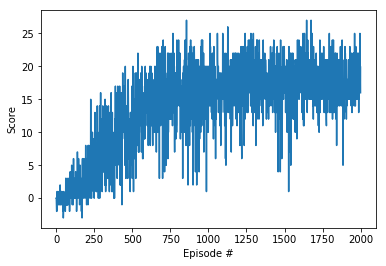

In [6]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    last_mean_score = 14.0
    last_lr = 0
    eps = eps_start                    # initialize epsilon
    scheduler = torch.optim.lr_scheduler.StepLR(agent.optimizer, step_size=750, gamma=0.05)

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0] 
        #state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]
            score += reward
            #if reward == 0:
            #    reward = -0.5
            done = env_info.local_done[0]
            #next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done,debugFlag=False)
            state = next_state

            if done:
                break 
        if i_episode < 1600:
            scheduler.step()
            lr = get_lr(agent.optimizer)
            if lr != last_lr:
                print('\nChanging lr from ' ,last_lr, ' to: ', lr)
                last_lr = lr
        #print(get_lr(agent.optimizer))
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            if np.mean(scores_window)>=last_mean_score:
                last_mean_score = np.mean(scores_window)
                #print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
                print('Saving...')
                torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
                #break
    torch.save(agent.qnetwork_local.state_dict(), 'last_checkpoint.pth')
    return scores

if TRAIN:
    scores = dqn(n_episodes=TRAIN_EPISODES)

    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()


Episode 100	Average Score: 17.62


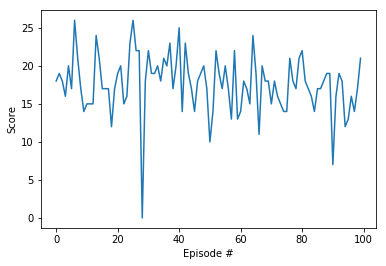

In [7]:
### test
if TEST:
    model_dict = TRAINED_FILENAME #'./checkpoint.pth'#'./DDQN_LR_750/checkpoint.pth'
    agent.qnetwork_local.load_state_dict(torch.load(model_dict))
    n_episodes = TEST_EPISODES
    max_t = 1000
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=False)[brain_name] # reset the environment
        state = env_info.vector_observations[0] 
        #state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, 0.0)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            #next_state, reward, done, _ = env.step(action)
            #agent.step(state, action, reward, next_state, done,debugFlag=False)
            state = next_state
            score += reward
            if done:
                break
            if VIS and VIS_TEST_SLOW:
                time.sleep(0.1) #--> to watch the game 
        #print(get_lr(agent.optimizer))
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
